In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
import cv2
import numpy as np
import pickle as pickle
import glob
import settings
%matplotlib inline

#### Load data from pickle files

In [2]:
data = pickle.load( open( "camera_calibration.p", "rb" ) )
camera_matrix = data['mtx']
dist_coeffs = data['dist']

perspective_transform_data = pickle.load(open("perspective.p", 'rb'))
x_pixels_per_meter = perspective_transform_data['x_pixels_per_meter']
y_pixels_per_meter = perspective_transform_data['y_pixels_per_meter']
M = perspective_transform_data['homography_matrix']
src_pts = perspective_transform_data['source_points']

### Image example

In [3]:
test_images = ['./test_images/straight_lines1.jpg', './test_images/straight_lines2.jpg']

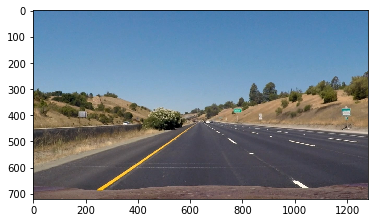

In [4]:
test_1 = mpimg.imread(test_images[0])
test_2 = mpimg.imread(test_images[1])
plt.imshow(test_1)

In [5]:
# import numpy as np
# import cv2
# im = cv2.imread(test_images[0])
# imgray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
# ret,thresh = cv2.threshold(imgray,127,255,0)
# print('ret: ', ret)
# print('thresh: ', thresh.
#       shape)
# im2, contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
# print('im2: ', im2.shape)
# print('contours: ', len(contours))
# plt.imshow(im2)
# cv2.drawContours(im, contours, -1, (0, 255, 0), 3)
# # plt.imshow(im)
# area = cv2.contourArea(contours[0])
# print('area: ', area)

### Lane Line Finder

In [7]:
class LaneLineFinder():
    """
    This class performs the individual calculations on a single lane line
    """
    def __init__(self, img_size, x_pixels_per_meter, y_pixels_per_meter, kind = 'none'):
        self.img_size = img_size
        self.x_pixels_per_meter = x_pixels_per_meter
        self.y_pixels_per_meter = y_pixels_per_meter
        self.kind = kind # specify left or right lane
        self.line_mask = np.ones((img_size[1], img_size[0]), dtype=np.uint8) # create 2D line mask
        
        

### Lane Finder

* For type uint8 LAB images the range is from (0, 255) for each channel
* Isolate green stuff by looking at the l in LAB. L = lightness,
* a: color opponents green-red
* b: color opponents blue-yellow, yellow has positive values, blue has negative values
        

In [77]:
class LaneFinder():
    def __init__(self, 
                 img_size, 
                 warped_size, 
                 camera_matrix, 
                 dist_coeffs,
                 transform_matrix,
                 x_pixels_per_meter, y_pixels_per_meter):
        self.img_size = img_size
        self.warped_size = warped_size
        self.camera_matrix = camera_matrix
        self.dist_coeffs = dist_coeffs
        self.transform_matrix = transform_matrix
        self.x_pixels_per_meter = x_pixels_per_meter
        self.y_pixels_per_meter = y_pixels_per_meter
        self.roi_mask = np.ones((self.warped_size[1], self.warped_size[0],3), dtype=np.uint8)
        self.mask = np.zeros((self.warped_size[1], self.warped_size[0], 3), dtype = np.uint8)
        self.real_mask = np.zeros((self.warped_size[1], self.warped_size[0],3), dtype = np.uint8)
        self.left_line = LaneLineFinder(warped_size, x_pixels_per_meter, y_pixels_per_meter, kind = 'left')
        self.right_line = LaneLineFinder(warped_size, self.x_pixels_per_meter, self.y_pixels_per_meter, kind = 'right') 
        
    def warp(self, img):
        return cv2.warpPerspective(img, self.transform_matrix, self.warped_size, 
                                   flags=cv2.WARP_FILL_OUTLIERS + cv2.INTER_NEAREST)
    
    def unwarp(self, img):
        return cv2.warpPerspective(img, self.transform_matrix, self.img_size, 
                                   flags = cv2.WARP_FILL_OUTLIERS + cv2.INTER_NEAREST + cv2.WARP_INVERSE_MAP)
    
    def undistort(self, img):
        return cv2.undistort(img, self.camera_matrix, self.dist_coeffs)
    
    def find_lane(self, image, distorted = True, reset = False):
        """
        Pipeline:
        1) Undistort
        2) Perspective Transform
        3) Blur
        4) Convert to HLS and LAB and use the Luminance channel to identify yellow lines
        """
        # 1) Undistort the image
        # TODO: Add conditional to flag distortion
        img = self.undistort(image)
        
        # 2) Apply perspective transform
        warped = self.warp(img)
        
        # 3) Blur
        blur_kernel = 5
        img_hls = cv2.cvtColor(warped, cv2.COLOR_RGB2HLS)
        img_lab = cv2.cvtColor(warped, cv2.COLOR_RGB2LAB)
        
        img_hls = cv2.medianBlur(img_hls, blur_kernel)
        img_lab = cv2.medianBlur(img_lab, blur_kernel)
        
#         # Get structuring element for morph transforms
#         # note: Select structuring element to be large enough so that it won't fit inside the objects to be removed
#         large_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (33, 33))
#         small_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
                
#         # The road is dark, so extract bright regions out of the image
#         # If L in HLS is greater than 190 then it is bright
#         # Also filter out low saturation < 50
#         hls_filter = cv2.inRange(img_hls, (0, 0, 50), (30, 186, 255))
        
#         nature = img_lab[:,:,2].astype(np.uint8) > 127
#         nature = hls_filter & nature
        
#         # now discount everything there that is not within the range of the mask
        
#         mask = np.logical_not(nature).astype(np.uint8)
#         # cut out the bright stuff
#         mask[img_hls[:,:,1] > 250] = 0
#         # perform OPEN morphology (erosion + dilation) to reduce noise
#         mask = cv2.morphologyEx(mask.astype(np.uint8), cv2.MORPH_OPEN, small_kernel)
        
#         # perform Dilation morphology for enhancement on larger features
#         mask = cv2.dilate(mask, large_kernel)
        
#         # get contours
#         im2, contours, heirarchy = cv2.findContours(mask,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
        
#         # find largest contour
#         largest_area = 0
#         largest_contour = contours[0]
#         for contour in contours:
#             if (cv2.contourArea(contour)) > largest_area:
#                 largest_area = cv2.contourArea(contour)
#                 largest_contour = contour
        
        
#         # zeros out the mask
#         mask = np.zeros_like(mask)
#         # now fill in the biggest contour
#         cv2.fillPoly(mask, [largest_contour], 1)
        

    
        # perform tophat (original - opening)
        tophat_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 3))
        black = cv2.morphologyEx(img_lab[:,:,0], cv2.MORPH_TOPHAT, tophat_kernel)
        lanes = cv2.morphologyEx(img_hls[:,:,1], cv2.MORPH_TOPHAT, tophat_kernel)
        
        rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (13, 13))
        yellow_lanes = cv2.morphologyEx(img_lab[:,:,2], cv2.MORPH_TOPHAT, rect_kernel)
        
        # Adaptive thresholding
        self.mask[:,:,0] = cv2.adaptiveThreshold(black, 50, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 13, -6)
        self.mask[:,:,1] = cv2.adaptiveThreshold(lanes, 60, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, -4)
        self.mask[:,:,2] = cv2.adaptiveThreshold(yellow_lanes, 60, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, -1.5)

        small_ellipse = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
        filtered = cv2.erode(self.mask[:,:,0], small_ellipse, iterations = 1)
        
        
        return self.mask[:,:,0]

In [78]:
laneFinder = LaneFinder(settings.ORIGINAL_SIZE, settings.UNWARPED_SIZE, camera_matrix, dist_coeffs, 
                        M, x_pixels_per_meter, y_pixels_per_meter)

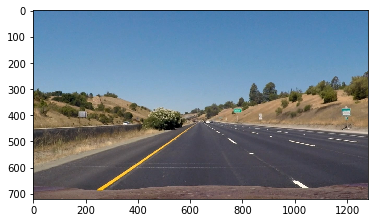

In [79]:
plt.imshow(test_1)

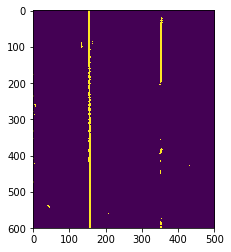

In [80]:
real_mask = laneFinder.find_lane(test_1)
plt.imshow(real_mask)

### Thresholding functions

In [ ]:
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    # 3) Take the absolute value of the derivative or gradient
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    # 6) Return this mask as your binary_output image
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    if orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
        
    abs_sobel = np.absolute(sobel)
    
    scaled_sobel = np.uint8(255 * abs_sobel/np.max(abs_sobel))

    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return binary_output

In [ ]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # grayscale
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # sobel x and y
    sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=sobel_kernel)
    sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=sobel_kernel)

    sobel_xy = np.sqrt(sobelx**2 + sobely**2)
    print('sobel_xy: ', sobel_xy)
    print(':: ',np.max(sobel_xy, axis = 0))
    print('sobel_xy: ', sobel_xy.shape)
    sf = np.max(sobel_xy/255)
    gradmag = (sobel_xy/sf).astype(np.uint8)
    
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    
    return binary_output

In [ ]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    abs_x= np.absolute(sobelx)
    abs_y = np.absolute(sobely)
    
    
    direction = np.arctan2(abs_y, abs_x)
    
    binary_output = np.zeros_like(direction)
    binary_output[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    return binary_output

In [ ]:
def color_threshold(img, sthresh=(0, 255), vthresh = (0, 255)):
    """
    This function takes in two thresholds, s in HLS and v in HSV and the image and it 
    returns the combination output binary of both gradients
    """
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    # 1) Convert to HLS color space
    # 2) Apply a threshold to the S channel
    
    # s channel
    s = hls[:,:,2]
    s_binary = np.zeros_like(s)
    s_binary[(s > sthresh[0]) & (s <= sthresh[1])] = 1
    
    # v channel
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    # isolate v channel
    v = hsv[:,:,2]
    v_binary = np.zeros_like(v)
    v_binary[(v > vthresh[0]) & (v <= vthresh[1])] = 1

    # create combination of both binaries as output
    output_binary = np.zeros_like(s)
    output_binary[(s_binary == 1) | (v_binary == 1)] = 255

    return output_binary